<div align="right"><i>COM418 - Computers and Music</i></div>
<div align="right"><a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>

<p style="font-size: 30pt; font-weight: bold; color: #B51F1F;">I like DSP and I Feel Fine</p>

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy import signal
from scipy.io import wavfile
import ipywidgets as widgets

plt.rcParams['figure.figsize'] = 14, 4 
matplotlib.rcParams.update({'font.size': 14})

In [2]:
DEFAULT_SF = 24000  

def play(x, sf=DEFAULT_SF):
    TAPER = 1000
    y = np.copy(x)
    y[:TAPER] *= np.linspace(0, 1, TAPER)
    y[-TAPER:] *= np.linspace(1, 0, TAPER)
    return Audio(y, rate=sf)

import ipywidgets as widgets
def multiplay(clips, rate=DEFAULT_SF, title=None):
    outs = [widgets.Output() for c in clips]
    for ix, item in enumerate(clips):
        with outs[ix]:
            display(play(item[0], sf=item[1]))
    return widgets.HBox(outs)

# "I Feel Fine" by the Beatles


<img src="img/beatles.png" alt="Drawing" style="float: left; width: 200px; margin: 20px 30px;"/>
 

 * recorded on October 18, 1964
 * one of the first (if not the first) example of distortion via feedback
 
 
> _"I defy anybody to find a record... unless it is some old blues record from 1922... that uses feedback that way. So I claim it for the Beatles. Before Hendrix, before The Who, before anybody. The first feedback on record."_ -- John Lennon

<audio controls src="snd/iff_long.mp3"></audio>

## A "forensic analysis" on the opening sound

We will try to synthesize digitally the distorted guitar sound using a variety of "computers and music" tools:

 * "witness accounts" from the recording session
 * spectral analysis
 * physical modeling
 * lots of trial and error

## What the "history books" say

 * Lennon's electro-acoustic guitar was leaning against an amp
 * McCartney played an A on the bass
 * the guitar's open A string started to resonate
 * the sound from the amp reinforced the vibration of the open string (positive feedback)
 * the amplitude of the string's vibration increased
 * the string started to hit the fretboard causing _fret buzz_

## The feedback loop, block diagram

<img src="img/hendrix.jpg" alt="Drawing" style="float: right; width: 400px; margin: 20px 0px;"/>


<img src="img/bd.png" alt="Drawing" style="float: left; width: 800px; margin: 20px 30px;"/>

* guitar $G$, with nonlinear fret buzz model
* amplifier $A$, with volume and tone controls
* feedback channel $F$, depending on guitar-amp distance

## Fact-finding exploration

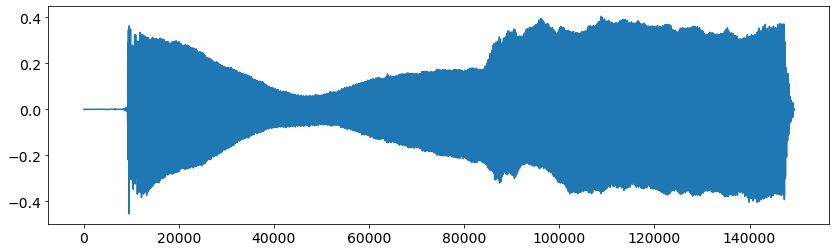

In [3]:
iff_sf, iff = wavfile.read("snd/iff.wav")
iff = (iff - np.mean(iff)) / 32767.0
plt.plot(iff)
Audio(iff, rate=iff_sf)

### Clean vs distorted sound in the time domain

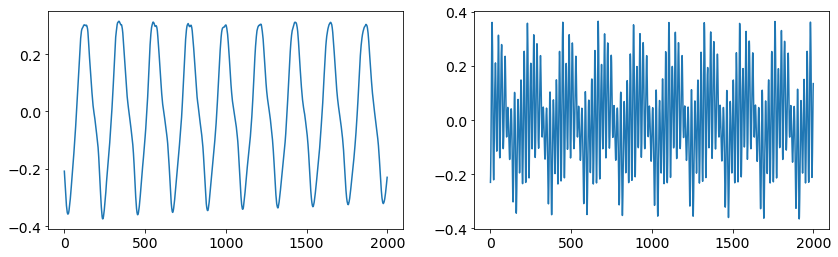

In [4]:
iff_beg, iff_end = iff[13000:40000], iff[120000:130000]
plt.subplot(1, 2, 1)
plt.plot(iff_beg[:2000]);   
plt.subplot(1, 2, 2)
plt.plot(iff_end[:2000]);   

### ...and in the frequency domain

In [5]:
def plot_spectrum(x, sf, fmax=None, dB=False, lw=2):
    if fmax is None or fmax > sf / 2:
        fmax = sf / 2
    N = int(len(x) * fmax / sf)
    X = np.abs(np.fft.fft(x)[0:N])
    if dB:
        X = 20 * np.log10(X)
    plt.plot(np.linspace(0, fmax, N), X, linewidth=lw)

Note the big difference in spectral content between the undistorted and the distorted sound: since we know that linear filters cannot add frequency components, the system is clearly non linear!

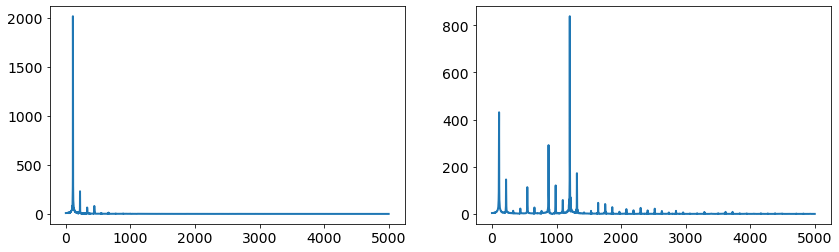

In [6]:
plt.subplot(1, 2, 1)
plot_spectrum(iff_beg, iff_sf, fmax=5000);   
plt.subplot(1, 2, 2)
plot_spectrum(iff_end, iff_sf, fmax=5000);   

# Technical prelude: some DSP blocks

## Magnitude response of digital filters

In the notebook we will use several digital filters whose transfer function can be expressed as 

$$
    H(z) = \frac{b_0 + b_1 z^{-1} + \ldots + b_{N-1}z^{-N+1}}{a_0 + a_1 z^{-1} + \ldots + a_{N-1}z^{-N+1}}
$$

The following function can be used to plot their magnitude response

In [7]:
def mag_resp(b, a, dB=False):
    """simple function to plot the magnitude response of a digital filter"""
    L = 32767
    X = np.fft.fftshift(np.abs(np.fft.fft(b, L) / np.fft.fft(a, L)))
    if dB:
        X = 20 * np.log10(X)
    plt.plot(np.linspace(-np.pi, np.pi, L), X)
    plt.xticks(np.pi * np.array([-1, -0.5, 0, 0.5, 1]), ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'])
    plt.grid()

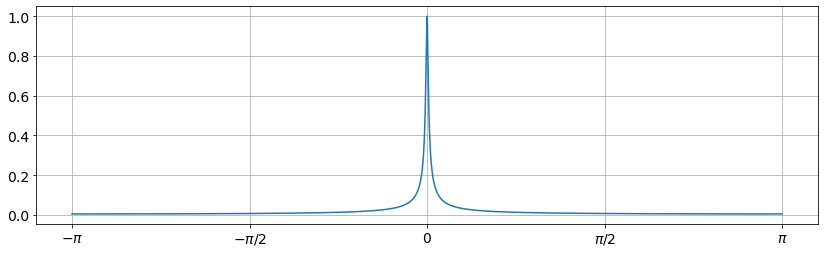

In [8]:
mag_resp([0.01], [1, -0.99])

## The biquad section

One of the most useful building blocks for applied DSP applications is the _biquad_ section, describing a generic second-order IIR filter

$$
    H(z) = \frac{b_0 + b_1 z^{-1} + b_{2}z^{-2}}{1 + a_1 z^{-1} + a_{2}z^{-2}}
$$

Useful on their own, but also to implement high-performance filters as a cascade of small, numerically stable sections.

<img src="img/biquad.png" alt="Drawing" style="float: right; width: 500px; margin: 30px 0px;"/>

We will implement the biquad section as a Python class:

 * Direct Form II implementation
 * stateful class (can be called iteratively)
 
Implementation is not efficient but it is versatile

In [9]:
class BiQuad():
    def __init__(self, b, a):
        assert len(b) == len(a) == 3 and a[0] == 1
        self.a, self.b = a, b
        self.a[0] = 0
        self.buf = np.zeros(3)
    
    def filter(self, x):
        y = np.zeros(len(x))
        for n, xn in enumerate(x):
            self.buf[0] = xn - self.a @ self.buf
            y[n] = self.b @ self.buf
            self.buf = np.roll(self.buf, 1)
        return y
    
    def reset(self):
        self.buf *= 0

## The PeakingEQ

One common specialization of the biquad section is the "peaking equalizer", namely a filter that can provide an arbitrary boost or attenuation for a given frequency band centered around a peak freqency. The filter is defined by the following parameters:

 1. the desired gain in dB (which can be negative)
 1. the peak frequency $f_c$, where the desired gain is attained
 1. the bandwidth of the filter, defined as the interval around $f_c$ where the gain is greater (or smaller, for attenuators) than half the desired gain in dB

In [10]:
def PEQ(fc, bw, gain, sf):
    """Biquad bandpass filter """
    w = 2 * np.pi * fc / sf
    A = 10 ** (gain / 40)    
    alpha = np.tan(np. pi * bw / sf)
    c = np.cos(w)
    b = np.array([1 + alpha * A, -2 * c, 1 - alpha * A])
    a = np.array([1 + alpha / A, -2 * c, 1 - alpha / A])
    return b / a[0], a / a[0]

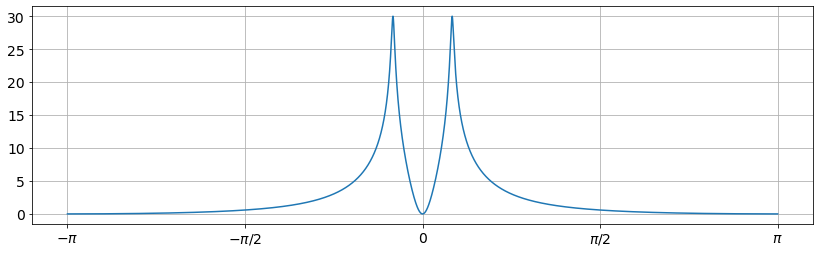

In [11]:
mag_resp(*PEQ(1000, 500, 30, DEFAULT_SF), dB=True)

# Simulating the guitar

* string model
* fret buzz

We will not try to model the attack phase of the note, only the quasi-periodic sustained tone.

## The vibrating string

We need to model the string as a input/output system:

 * input is the action on the string (picking and/or sound from the amp)
 * output is a signal compatible with the physical properties of a vibrating string.

### Standing waves

<img width="450" style="float: right; margin: 10px 20px;" src="img/monochord.png">

The motion of A vibrating string can be decomposed into the sum of harmonic standing waves with frequencies

$$ f_n = \frac{n}{2L}\sqrt{\frac{T}{\mu}} $$

 * $L$ length ($m$)
 * $T$ tension ($N = {kg}~ m/s^2$)
 * $\mu$ linear density ($kg/m$)
 
 

<img width="250" style="float: left; margin: 10px 100px 0 0;" src="img/string.gif">

A guitar string acts as a bank of resonators at multiples of the fundamental frequency.

Of course, because of energy dissipation, the amplitude of the oscillations decays over time

### Modeling a dampened vibration

Remember the simple resontator, where $\omega_0$ is the center frequency and $\rho \approx 1$ determines the rate of decay:

$$
\begin{align*}
  H(z) &= \frac{1}{(1 - \rho e^{j\omega_0}z^{-1})(1 - \rho e^{-j\omega_0}z^{-1})}, \quad \rho \approx 1 \\ \\
       &= \frac{1}{1 - 2\rho \cos\omega_0 z^{-1} + \rho^2 z^{-1}}
\end{align*}
$$

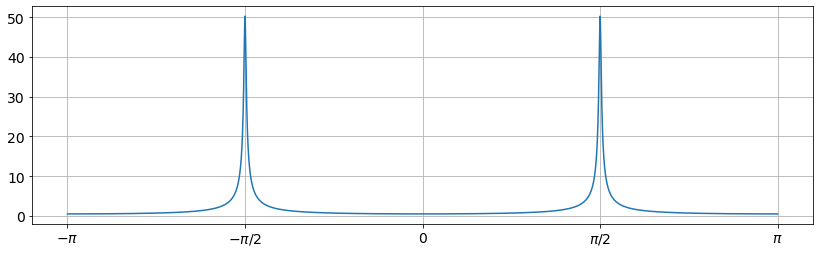

In [12]:
rho, w0 = 0.99, np.pi / 2
mag_resp([1], [1, -2 * rho * np.cos(w0), rho * rho])

### Implementing a basic resonator

In [13]:
class Resonator(BiQuad):
    def __init__(self, theta, rho=0.9999):
        gain = (1 + rho) / 4
        b = np.array([gain, 0, -gain])
        a = np.array([1, -2 * rho * np.cos(theta), rho * rho])
        super().__init__(b, a)       

Let's test it:

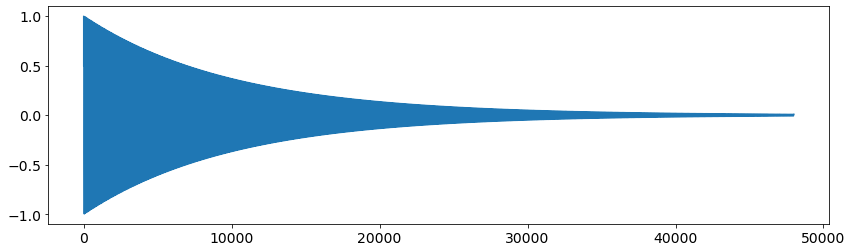

In [14]:
y = Resonator(2 * np.pi * 300 / DEFAULT_SF).filter(np.r_[1, np.zeros(2 * DEFAULT_SF)])
plt.plot(y);
play(y)

### Modeling the clean guitar tone

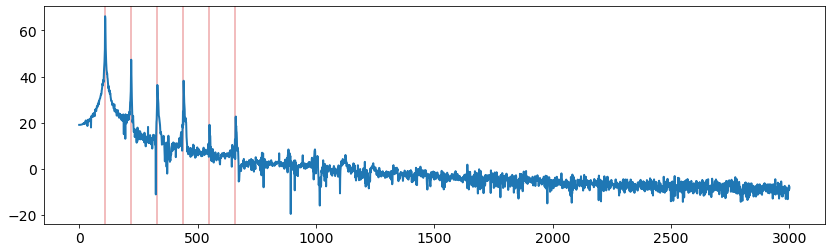

In [15]:
for n in range(1, 7):
    plt.axvline(110 * n, color='C3', alpha=.4)
plot_spectrum(iff_beg, iff_sf, fmax=3000, dB=True);  

By looking at the specturm of the clear guitar tone we can see that:

 * there is a clear harmonic structure
 * the fundamental frequency is 110Hz, which corresponds to the pitch of a guitar's open A string
 * there are only a few significant overtones

We will model the open string using a bank of harmonic resonators (additive synthesis)  

In [16]:
class String():
    def __init__(self, pitch=110.0, rho=0.9999, overtones=[], sf=DEFAULT_SF):
        theta = 2 * np.pi * pitch / sf # digital frequency
        overtones = [1, ] + overtones  # add overtones to fundamental
        self.harmonics = [{
            'gain': gain, 
            'res' : Resonator((n+1) * theta, rho)
        } for n, gain in enumerate(overtones)]
        self.gain = 1.0 / np.sum([np.abs(p['gain']) for p in self.harmonics])
        
    def vibrate(self, x):
        y = self.harmonics[0]['gain'] * self.harmonics[0]['res'].filter(x)
        for p in self.harmonics[1:]:
            y = y + p['gain'] * p['res'].filter(x)
        return y * self.gain
    
    def reset(self):
        for p in self.harmonics:
            p['res'].reset()

Let's test it out, using empirical relative amplitudes of the partials from the spectral plot of the clean tone

In [17]:
A_string = String(pitch=110.0, overtones=[-0.075, 0.035, -0.032, 0.0035, -0.0065])
y = A_string.vibrate(np.r_[1, np.zeros(3 * DEFAULT_SF)])
multiplay([(y, DEFAULT_SF), (iff_beg, iff_sf)])

<img src="img/buzz.jpg" alt="Drawing" style="float: right; width: 300px; margin: 0px 30px;"/>

## The fret buzz

When a string oscillates too widely, it will end up bumping against the fretboard. We can approximate this effect by introducing a limiting nonlinearity.

In [18]:
def fret_buzz(x, threshold):
    out = np.where(x > threshold, threshold, x)
    out = np.where(out < -threshold, -threshold, out)
    return out

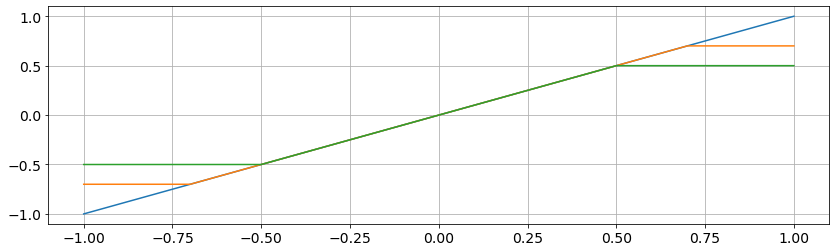

In [19]:
x = np.linspace(-1, 1, 301)
for t in [1, 0.7, 0.5]:
    plt.plot(x, fret_buzz(x, t))
plt.grid()

In [20]:
multiplay([(fret_buzz(y, 1), DEFAULT_SF), (fret_buzz(y, 0.3), DEFAULT_SF), (fret_buzz(y, 0.1), DEFAULT_SF)])

Note how the nonlinearity introduces a lot of extra frequency content

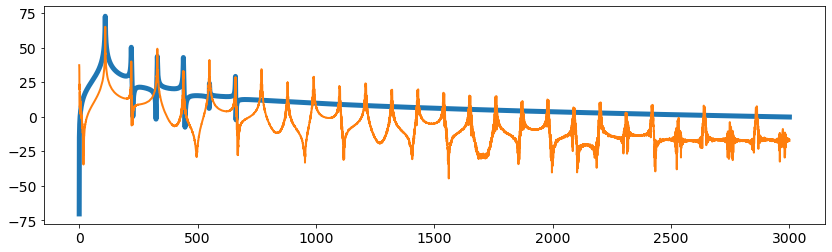

In [21]:
plot_spectrum(y, DEFAULT_SF, fmax=3000, dB=True, lw=5);   
plot_spectrum(fret_buzz(y, 0.1), DEFAULT_SF, fmax=3000, dB=True);   

# The feedback

In "I Feel Fine" the fret buzz appears when the sound from the amplifier drives the A string into wider and wider oscillations. To model this effect we need to simulate a feedback path.

## Sustained excitation

So far we have triggered the string with an instantaneous "pluck", that is with a delta sequence. But we could use other inputs:

In [22]:
# exciting the resonators with white noise produces a flute-like sound
play(String(300).vibrate(np.random.rand(2 * DEFAULT_SF)))

In [23]:
# exciting the resonators with a sawtooth produces a violin-like sound
play(String(300).vibrate(signal.sawtooth(2 * np.pi * 150 / DEFAULT_SF * np.arange(0, 2 * DEFAULT_SF))))

A sustained sound can keep the string vibrating (**sympathetic vibration**); this is the basic principle behind feedback-induced distortion.

In [24]:
y = String(110).vibrate(String(110, rho=0.99999).vibrate(np.r_[1, np.zeros(2 * DEFAULT_SF)]))
play(y)

## Feedback examples

In [25]:
def simple_feedback(string, gain, delay):
    N = 3 * DEFAULT_SF  # three-second examples
    x, y = 1, np.zeros(N)     
    string.reset()
    for n in range(0, N):
        y[n] = string.vibrate([x]) 
        x = 0 if n < DEFAULT_SF else gain * y[(n - delay) % N]
    plt.plot(y);
    return y

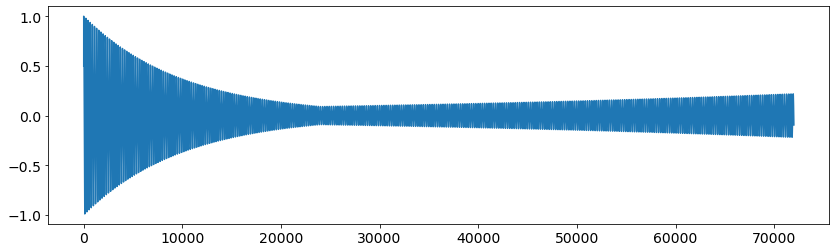

In [26]:
A_string = String(pitch=110)

y = simple_feedback(A_string, 0.001, 46)
play(y)

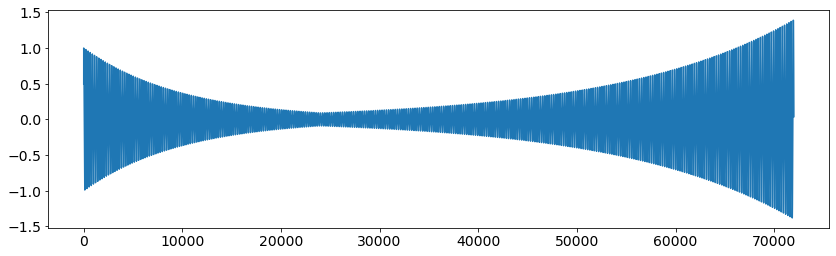

In [27]:
y = simple_feedback(A_string, 0.0013, 46)
play(y)

Of course, since we are in the presence of _positive_ feedback, the gain level is crucial for stability

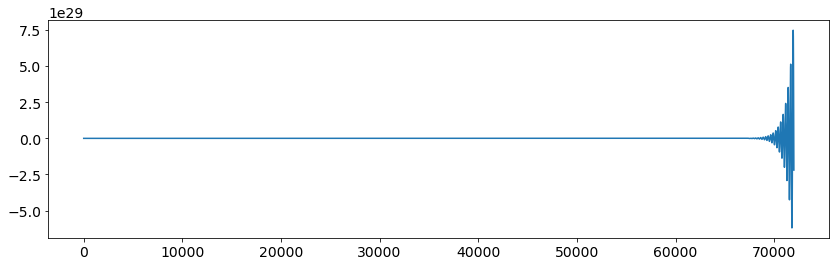

In [28]:
y = simple_feedback(A_string, 0.01, 46)

Depending on the feedback gain and delay, only certain modes of the string can be excited:

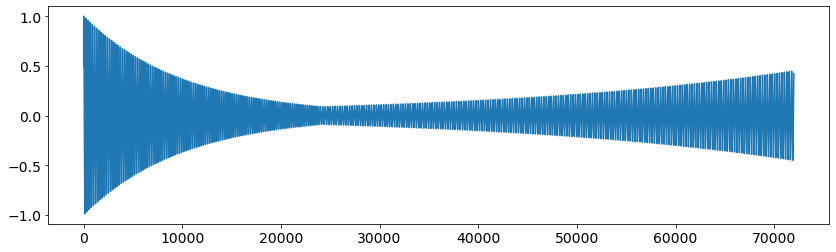

In [29]:
y = simple_feedback(A_string, 0.007, 59)
play(y)

<img src="img/amp.jpg" alt="Drawing" style="float: right; width: 400px; margin: 30px 0 0 30px;"/>

# The amp

In the current setup, the amplifier is responsible for some slight _equalization_ of the guitar sound. We are going to cut a bit the bass end and boost the midrange using two peaking equalizers in series

In [30]:
class ToneControls():
    def __init__(self, sf=DEFAULT_SF):
        self.knobs = [
            BiQuad(*PEQ(330, 100, -20, sf)),   # cut low end
            BiQuad(*PEQ(1200, 400, 35, sf)),   # boost midrange
        ]
    
    def filter(self, x):
        y = np.copy(x)
        for k in self.knobs:
            y = k.filter(y)
        return y
    
    def reset(self):
        for k in self.knobs:
            k.reset()

The overall magnitude response of the equalizer is like so:

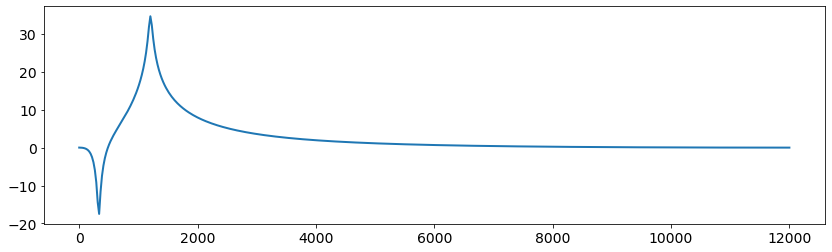

In [31]:
x = ToneControls().filter(np.r_[1, np.zeros(1000)])
plot_spectrum(x, DEFAULT_SF, dB=True)

# The acoustic channel

The feedback loop is completed by taking into account the transfer of energy from the amp's loudspeaker to the A string. 

For feedback to kick in, two things must happen:

* the energy transfer from the pressure wave to the vibrating string should be non-negligible
* the phase of the vibrating string must be sufficiently aligned with the phase of the sound wave in order for the sound wave to "feed" the vibration.

Sound travels in the air at about 340 meters per second and sound pressure (that is, signal amplitude) decays with the reciprocal of the traveled distance. We can build an elementary acoustic channel simulation by neglecting everything except delay and attenuation. The output of the acoustic channel for a guitar-amplifier distance of $d$ meters will be therefore

$$
	y[n] = (\alpha/d) x[n-M]
$$

where $\alpha$ is the coupling coefficient between amp and string at a reference distance of 1m, $d$ is the distance between guitar and amplifier, and $M$ is the propagation delay in samples; with an internal clock of $F_s$ Hz we have $M = \lfloor d/(c F_s) \rfloor$ where $c$ is the speed of sound.

In [32]:
def coupling_params(distance, sf=DEFAULT_SF):
    SPEED_OF_SOUND = 343
    REF_DIST, COUPLING_COEF = 1, 0.000025 # - 80dB
    delay = int(distance / SPEED_OF_SOUND * sf)
    att = COUPLING_COEF / distance * REF_DIST
    return att, delay

# Play it, Johnnie

We simulate the recording studio events by plucking the string and moving the guitar very close to the amp after a few moments

We will synthesize a few seconds of sound, one sample at a time, following these steps:

* generate a guitar sample
* apply the fret buzz nonlinearity (which will kick in only after the signal exceeds a certain level)
* filter the sample with the equalizer
* feed it back to the guitar via the acoustic channel using a time-varying distance

During the simulation, we will change the distance used in the feedback channel model to account for the fact that the guitar is first played at a distance from the amplifier, and then it is placed very close to it. In the first phase, the sound will simply be a decaying note and then the feedback will start moving the string back in full swing and drive the amp into saturation. 

In [33]:
A_string = String(pitch=110)
amp = ToneControls()

# create a trajectory for the guitar, from A to B (in meters)
A, B = 1.5, 0.05
position = np.r_[
    np.linspace(A, B, int(1 * DEFAULT_SF)), # one second to get close to the amp
    np.ones(int(3 * DEFAULT_SF)) * B        # remain there for 3 seconds
]
N = len(position)
x, y = 1, np.zeros(N)           

for n in range(0, N):
    y[n] = amp.filter(fret_buzz(A_string.vibrate([x]), 1))
    att, delay = coupling_params(position[n])
    x = att * y[(n - delay) % N]

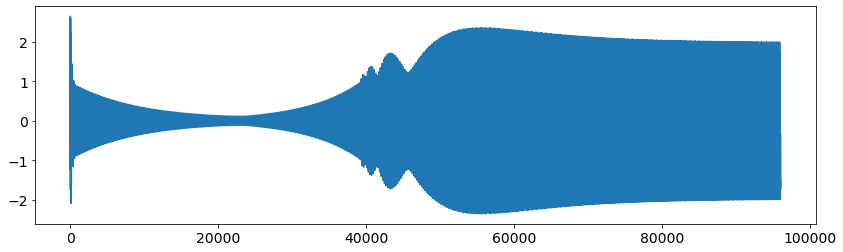

In [34]:
plt.plot(y);
multiplay([(y, DEFAULT_SF), (iff, iff_sf)])

# So much is still missing...

 * complicated nonlinear behavior for guitar strings amplifiers:
   * vibrating string spectrum varies with oscillation max amplitude
   * string spectrum not perfectly harmonic due string stiffness
   * amp loudspeaker becomes nonlinear if driven too hard

* we have neglected the frequency response of the guitar body
* there is certainly a lot more equalization deployed in the various phases of the recording process

Things you can play with: 

 * try to change the characteristic of the fret buzz
 * change the gain, the coupling loss or the frequency of the guitar
 * change the guitar position and verify that feedback does not occur at all distances.